In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
path = '../Wimbledon_featured_matches.csv'
df = pd.read_csv(path)
# df.info()

In [3]:
target_match_ids = df['match_id'].unique().tolist()
# target_match_id = '2023-wimbledon-1701'
# filtered_data = df[df['match_id'] == target_match_id].copy()
# filtered_data = df.copy()

In [4]:
"""
计算综合势头得分函数
"""
def calculate_comprehensive_momentum(data, player_number, window_size=10, alpha=0.02):
    momentum_scores = [0] * len(data)
    consecutive_point_wins = 0  # 追踪连续得分
    consecutive_game_wins = 0  # 追踪连续获胜的局数
    previous_game_winner = None  # 追踪上一局的获胜者
    initial_break_point_value = 1  # 破发的基础势头得分增加值
    ema = 0  # 初始EMA值

    for i in range(1, len(data)):
        recent_data = data[max(0, i - window_size):i]
        momentum_score = 0

        for _, feature in recent_data.iterrows():
            # 基本的势头得分计算
            P_t = 1 if feature['point_victor'] == player_number else -1
            S_t = 1.2 if feature['server'] == player_number else 1.0
            base_momentum = P_t * S_t
            momentum_score += base_momentum
            break_point_value = initial_break_point_value  # 重置破发得分值

            # 连续得分补正（线性）
            if P_t == 1:
                consecutive_point_wins += 1
            else:
                consecutive_point_wins = 0  # 在失分时重置
            momentum_score += 0.03 * consecutive_point_wins  # 每连续获胜增加额外得分

            # 连续小局获胜补正（线性）
            if feature['game_victor']:
                current_game_winner = feature['game_victor']
                if current_game_winner == player_number:
                    if current_game_winner == previous_game_winner:
                        consecutive_game_wins += 1
                    else:
                        consecutive_game_wins = 0  # 重置连续获胜局数
                previous_game_winner = current_game_winner
                momentum_score += 0.2 * consecutive_game_wins  # 连续获胜局数的影响

            # 大比分差距补正（指数）
            if feature['set_victor']:
                player1_set = feature['p1_sets'] + 1 if feature['set_victor'] == player_number else feature['p1_sets']
                player2_set = feature['p2_sets'] + 1 if feature['set_victor'] == player_number else feature['p2_sets']
                diff = (player2_set - player1_set) * (-1 ** player_number)  # player1为-1， player2为+1
                momentum_score += 0.1 * (2 ** diff)

            # 小比分差距补正（线性）
            if feature['game_victor']:
                score_diff = abs(feature['p1_games'] - feature['p2_games'])
                momentum_score += 0.02 * score_diff * P_t

            # 错失破发点对破发的势头得分增加值的削弱
            if feature['p1_break_pt_missed'] == 1 or feature['p2_break_pt_missed'] == 1:
                break_point_value -= 0.1  # 削弱的权值

            # (被)破发的影响
            if feature['p1_break_pt_won'] == 1 or feature['p2_break_pt_won'] == 1:
                break_point_value = max(break_point_value, 0.1)
                momentum_score += break_point_value * P_t

            # 拍数和跑动距离的影响
            rally_factor = feature['rally_count'] / 30  # 归一化回合数
            distance_factor = (feature['p1_distance_run'] + feature['p2_distance_run']) / 122  # 归一化跑动距离
            momentum_score += 2.0 * rally_factor * distance_factor * P_t
            
            # 使用指数移动平均平滑 momentum_score
            ema = alpha * momentum_score + (1 - alpha) * ema
                
            momentum_scores[i] = ema

    return momentum_scores

特征：point_victor, server, game_victor, set_victor, p1_sets, p2_sets, p1_games, p2_games, p1_break_pt_missed, p2_break_pt_won, rally_count, p1_distance_run, p2_distance_run

Player 1 had a Positive shift at point number 124, during set 2, game 9. GET 1.3535758726108709
Player 1 had a Positive shift at point number 125, during set 2, game 9. GET 1.2435099413260984
Player 1 had a Positive shift at point number 126, during set 2, game 10. GET 1.2122046804069901
Player 1 had a Negative shift at point number 130, during set 2, game 10. GET -1.0173331741880665
Player 1 had a Negative shift at point number 131, during set 2, game 10. GET -1.097856109798541
Player 1 had a Negative shift at point number 132, during set 2, game 11. GET -1.1157855470828486
Player 1 had a Positive shift at point number 187, during set 3, game 5. GET 1.2189597483823278
Player 1 had a Positive shift at point number 188, during set 3, game 5. GET 1.0816286156797474
Player 1 had a Negative shift at point number 196, during set 3, game 7. GET -1.104869406509633
Player 1 had a Negative shift at point number 197, during set 3, game 7. GET -1.1606765694515788
Player 1 had a Negative shift at 

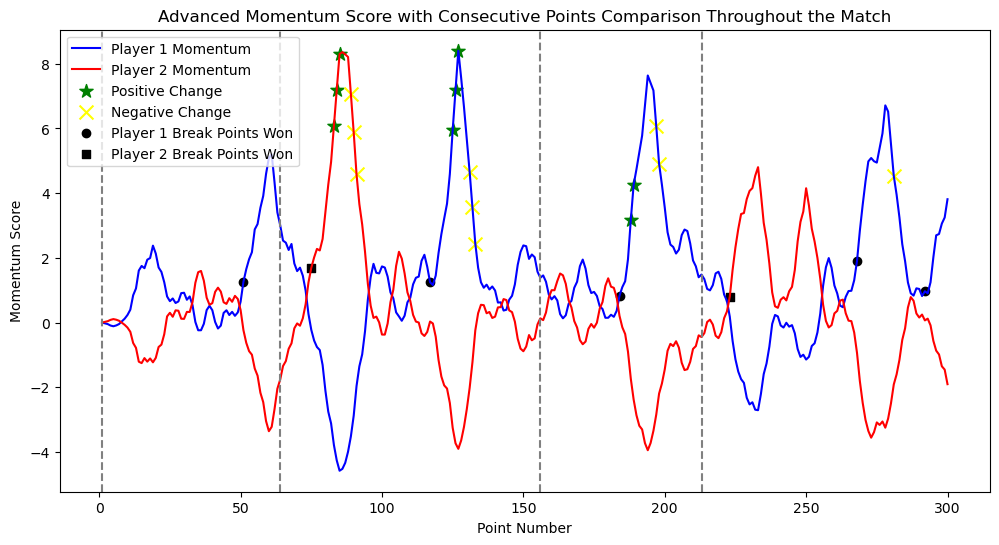

Player 2 had a Negative shift at point number 130, during set 3, game 3. GET -1.1712111218627603
Player 2 had a Negative shift at point number 131, during set 3, game 3. GET -1.357135489602903


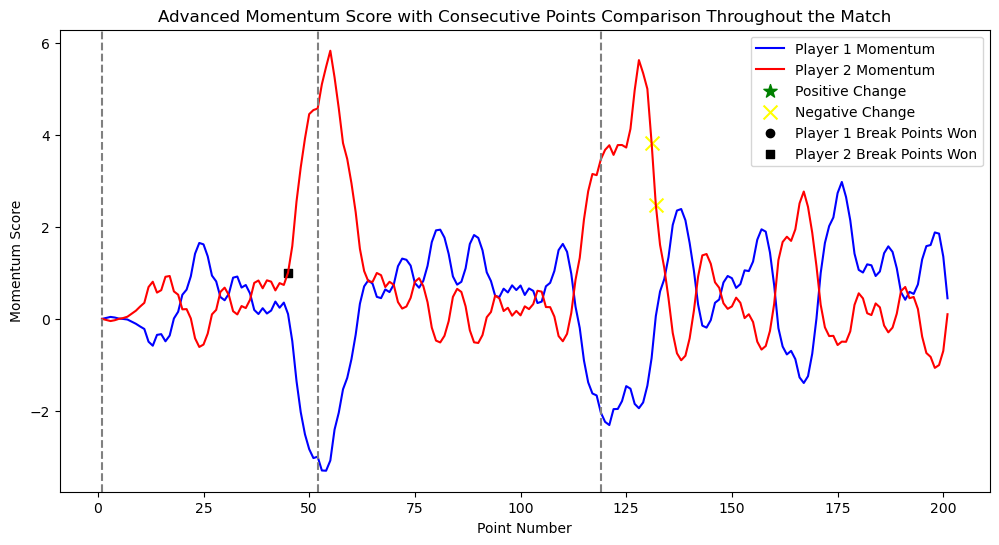

Player 1 had a Positive shift at point number 94, during set 3, game 1. GET 1.0831112579296125
Player 2 had a Positive shift at point number 45, during set 1, game 8. GET 1.1272446037170596
Player 2 had a Positive shift at point number 58, during set 2, game 2. GET 1.3852796193239652
Player 2 had a Negative shift at point number 60, during set 2, game 3. GET -1.734839398982368
Player 2 had a Negative shift at point number 61, during set 2, game 3. GET -1.5853829995508342
Player 2 had a Negative shift at point number 62, during set 2, game 3. GET -1.4655646794585948
Player 2 had a Negative shift at point number 63, during set 2, game 4. GET -1.3700986416447067
Player 2 had a Positive shift at point number 80, during set 2, game 7. GET 1.161317415847539
Player 2 had a Positive shift at point number 81, during set 2, game 7. GET 1.094457889506292
Player 2 had a Positive shift at point number 82, during set 2, game 7. GET 1.062871354058168
Player 2 had a Positive shift at point number 85, 

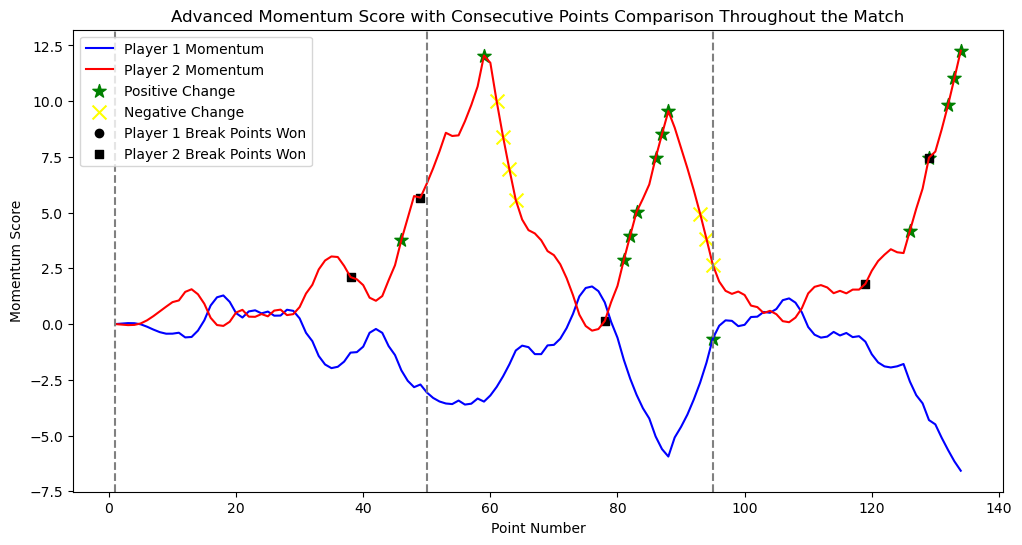

Player 1 had a Positive shift at point number 72, during set 2, game 4. GET 1.1960502064306042
Player 1 had a Positive shift at point number 73, during set 2, game 4. GET 1.053836736137146
Player 1 had a Negative shift at point number 82, during set 2, game 6. GET -1.0240626078406674
Player 1 had a Negative shift at point number 83, during set 2, game 6. GET -1.1549886643043346
Player 1 had a Negative shift at point number 84, during set 2, game 6. GET -1.299420610091211
Player 1 had a Negative shift at point number 86, during set 2, game 6. GET -1.0598692566382253
Player 1 had a Positive shift at point number 108, during set 2, game 9. GET 1.0942445423833123
Player 1 had a Positive shift at point number 109, during set 2, game 9. GET 1.3426712510732348
Player 1 had a Positive shift at point number 110, during set 2, game 9. GET 1.1226940144973225
Player 1 had a Negative shift at point number 142, during set 3, game 6. GET -1.0680488585407302
Player 1 had a Negative shift at point numb

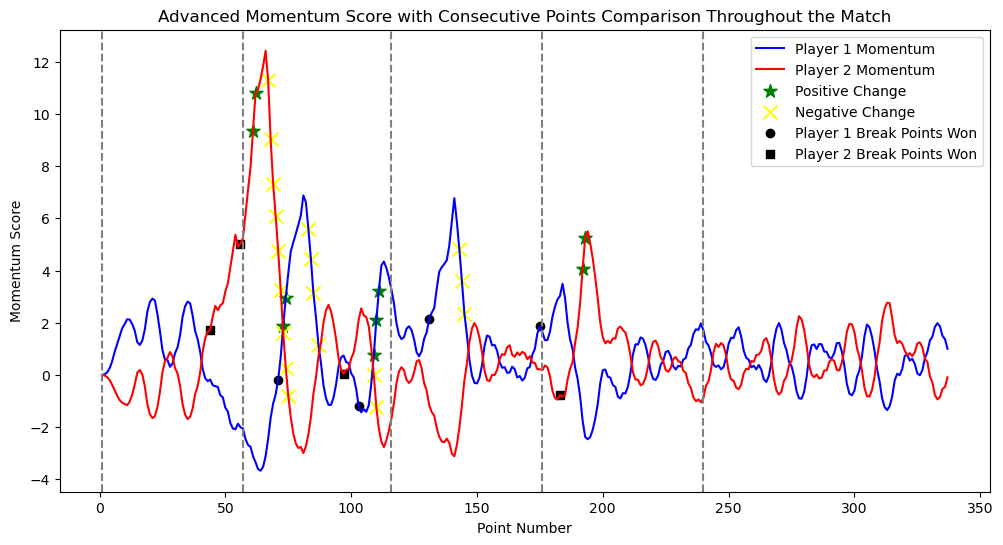

Player 1 had a Positive shift at point number 86, during set 2, game 4. GET 1.0394856171994227
Player 1 had a Positive shift at point number 88, during set 2, game 5. GET 1.4048406601915522
Player 1 had a Positive shift at point number 89, during set 2, game 5. GET 1.2183834148614072
Player 1 had a Positive shift at point number 90, during set 2, game 5. GET 1.6912311304516492
Player 1 had a Positive shift at point number 91, during set 2, game 5. GET 1.5824096060470128
Player 1 had a Positive shift at point number 92, during set 2, game 5. GET 1.3901242358950316
Player 1 had a Negative shift at point number 97, during set 2, game 6. GET -1.1015527662832687
Player 1 had a Negative shift at point number 98, during set 2, game 6. GET -1.0143617333098707
Player 1 had a Positive shift at point number 125, during set 3, game 2. GET 1.362039302677843
Player 1 had a Positive shift at point number 126, during set 3, game 3. GET 1.3493151263292855
Player 1 had a Positive shift at point number 1

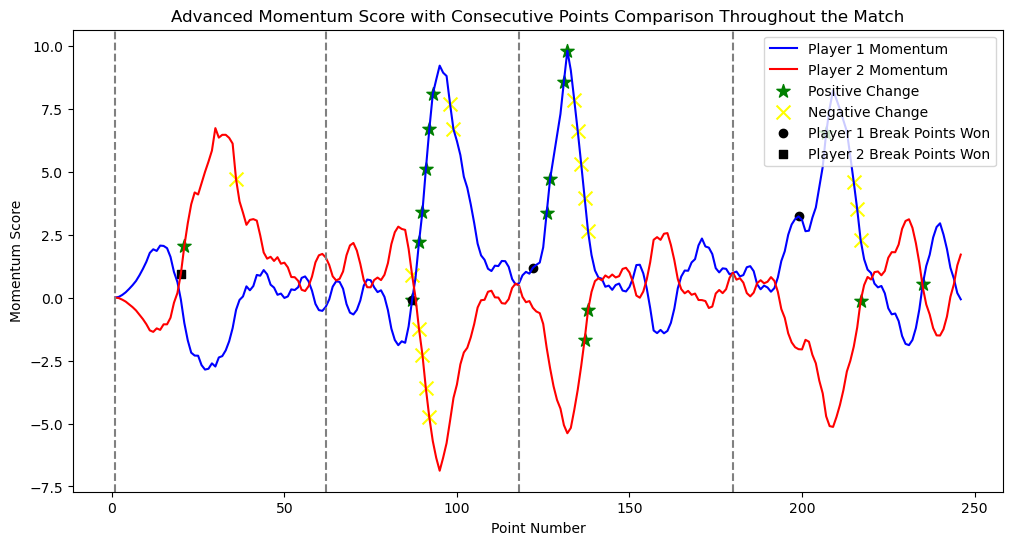

Player 1 had a Positive shift at point number 34, during set 1, game 6. GET 1.3420243836095969
Player 1 had a Positive shift at point number 35, during set 1, game 6. GET 1.3112190876072987
Player 1 had a Positive shift at point number 36, during set 1, game 6. GET 1.315987738246979
Player 1 had a Positive shift at point number 40, during set 1, game 7. GET 1.075296371190655
Player 1 had a Positive shift at point number 41, during set 1, game 7. GET 1.1104849017950755
Player 1 had a Negative shift at point number 44, during set 1, game 8. GET -1.5270215864363674
Player 1 had a Negative shift at point number 45, during set 1, game 8. GET -1.490632449775454
Player 1 had a Negative shift at point number 46, during set 1, game 8. GET -1.4383002859429057
Player 1 had a Negative shift at point number 47, during set 1, game 8. GET -1.3955501645630024
Player 1 had a Negative shift at point number 127, during set 3, game 3. GET -1.1060593704913453
Player 1 had a Negative shift at point number 1

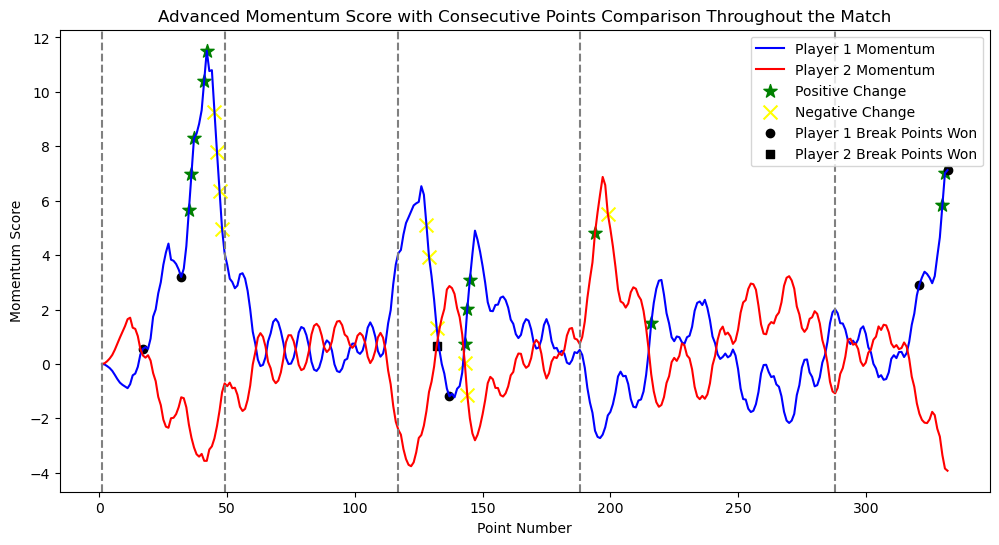

Player 1 had a Negative shift at point number 49, during set 1, game 9. GET -1.183390341082871
Player 2 had a Positive shift at point number 49, during set 1, game 9. GET 1.2810362727950964
Player 2 had a Positive shift at point number 50, during set 1, game 9. GET 1.092131918515661
Player 2 had a Positive shift at point number 52, during set 1, game 9. GET 1.2386315343820513
Player 2 had a Positive shift at point number 53, during set 1, game 9. GET 1.1708673882545302


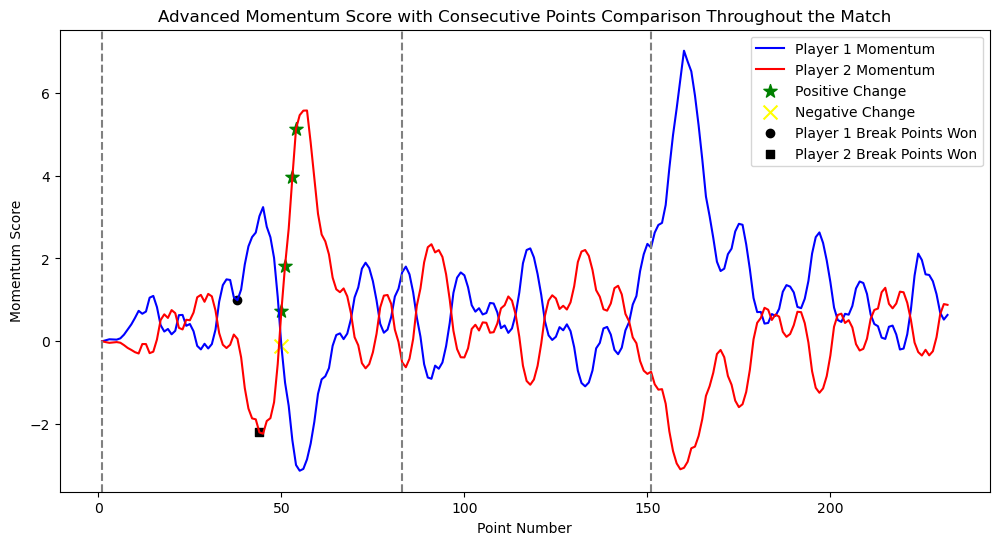

Player 1 had a Positive shift at point number 78, during set 2, game 3. GET 1.015864766476454
Player 2 had a Negative shift at point number 71, during set 2, game 2. GET -1.1223126996860162
Player 2 had a Negative shift at point number 110, during set 2, game 9. GET -1.0973637300733259
Player 2 had a Positive shift at point number 167, during set 3, game 6. GET 1.116093602058883
Player 2 had a Negative shift at point number 172, during set 3, game 6. GET -1.011899309117947
Player 2 had a Negative shift at point number 173, during set 3, game 7. GET -1.0822126047663845


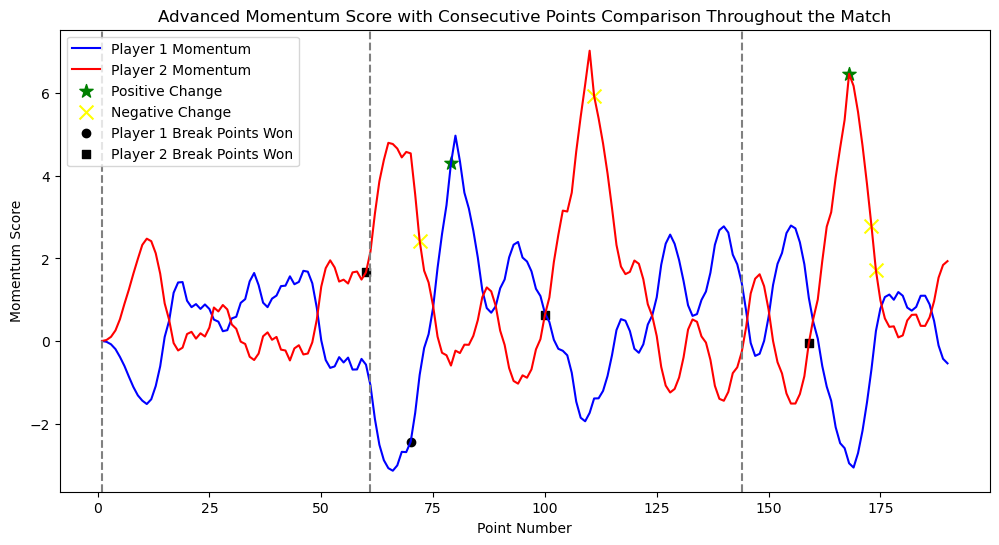

Player 2 had a Negative shift at point number 174, during set 4, game 4. GET -1.0157738279198854


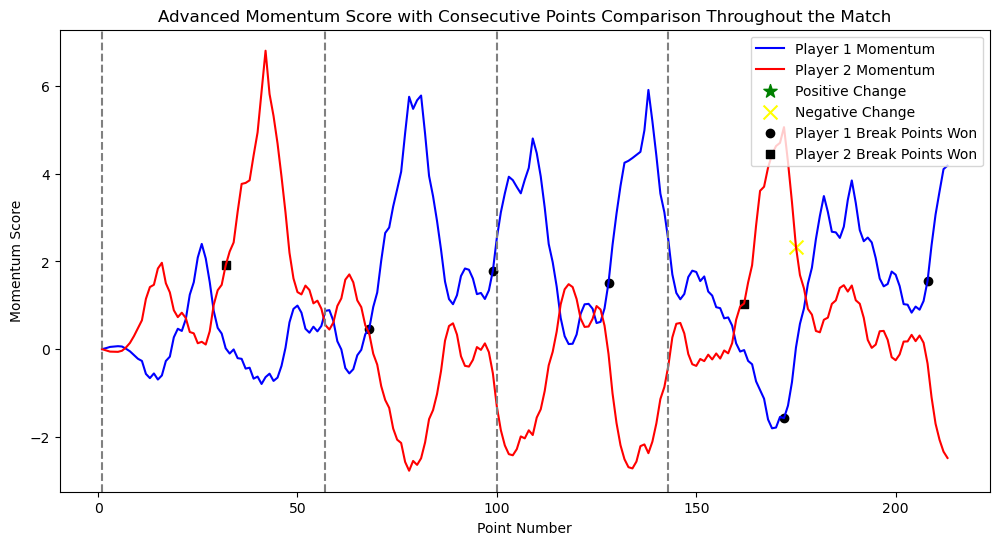

Player 1 had a Positive shift at point number 43, during set 1, game 6. GET 1.171366933934964
Player 1 had a Positive shift at point number 44, during set 1, game 6. GET 1.1139887330403475
Player 1 had a Positive shift at point number 49, during set 1, game 7. GET 1.0540913712641116
Player 1 had a Positive shift at point number 58, during set 2, game 1. GET 1.0137822360776312
Player 1 had a Positive shift at point number 59, during set 2, game 1. GET 1.1183796507489028
Player 1 had a Positive shift at point number 60, during set 2, game 2. GET 1.390168475576246
Player 1 had a Negative shift at point number 61, during set 2, game 2. GET -2.1827510245659703
Player 1 had a Negative shift at point number 62, during set 2, game 2. GET -2.0344315564958393
Player 1 had a Negative shift at point number 63, during set 2, game 2. GET -1.4240016337233738
Player 1 had a Negative shift at point number 64, during set 2, game 2. GET -1.4142243023647927
Player 1 had a Negative shift at point number 65

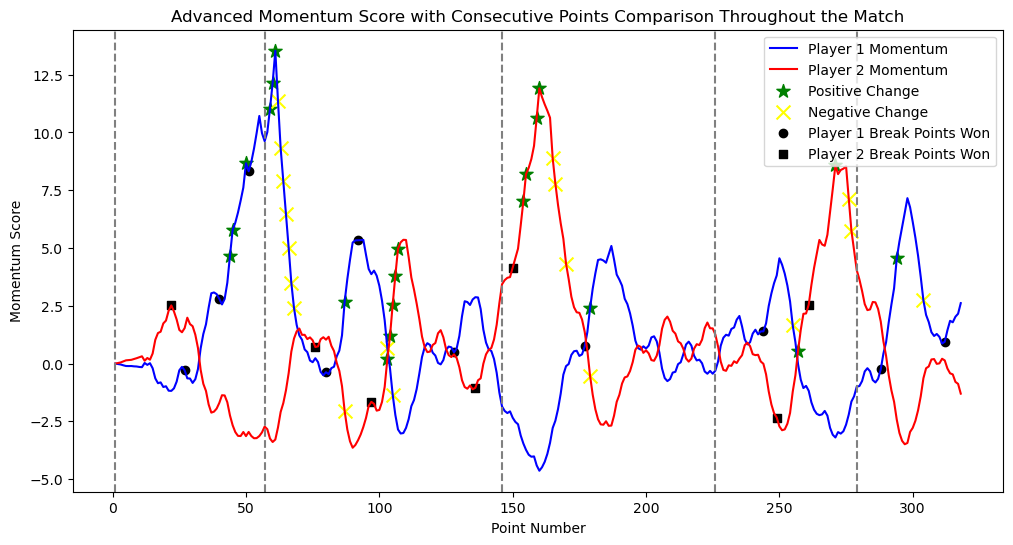

Player 1 had a Positive shift at point number 24, during set 1, game 4. GET 1.0386082954743483
Player 2 had a Positive shift at point number 158, during set 3, game 4. GET 1.0531444290205965
Player 2 had a Positive shift at point number 164, during set 3, game 6. GET 1.8740584795807038
Player 2 had a Positive shift at point number 166, during set 3, game 6. GET 1.240136395742848
Player 2 had a Positive shift at point number 167, during set 3, game 6. GET 1.161527564541844
Player 2 had a Positive shift at point number 168, during set 3, game 6. GET 1.3904665692917657
Player 2 had a Positive shift at point number 169, during set 3, game 6. GET 1.6225442594678867


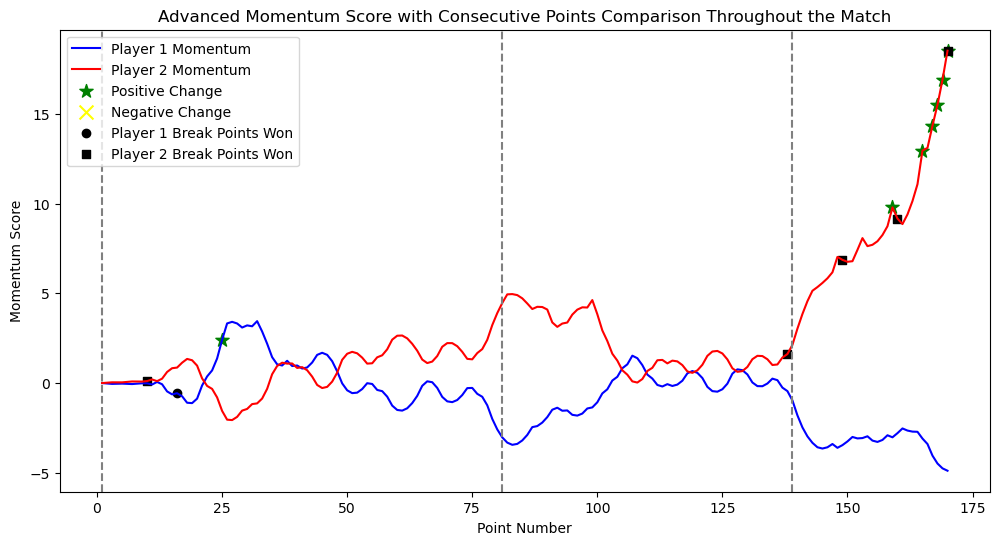

Player 1 had a Positive shift at point number 134, during set 3, game 1. GET 1.0381269250805252
Player 1 had a Negative shift at point number 140, during set 3, game 2. GET -1.2938029352569993
Player 1 had a Negative shift at point number 141, during set 3, game 2. GET -1.3532871779148552
Player 1 had a Negative shift at point number 143, during set 3, game 2. GET -1.0065660213620569
Player 1 had a Positive shift at point number 195, during set 3, game 10. GET 1.2864481823270615
Player 1 had a Positive shift at point number 196, during set 3, game 10. GET 1.1293076780881655
Player 1 had a Positive shift at point number 198, during set 3, game 11. GET 1.1730811216114354
Player 1 had a Positive shift at point number 199, during set 3, game 11. GET 1.2058929171145891
Player 1 had a Positive shift at point number 200, during set 3, game 11. GET 1.2758112072306194
Player 1 had a Positive shift at point number 201, during set 3, game 12. GET 1.325287475313445
Player 1 had a Positive shift at

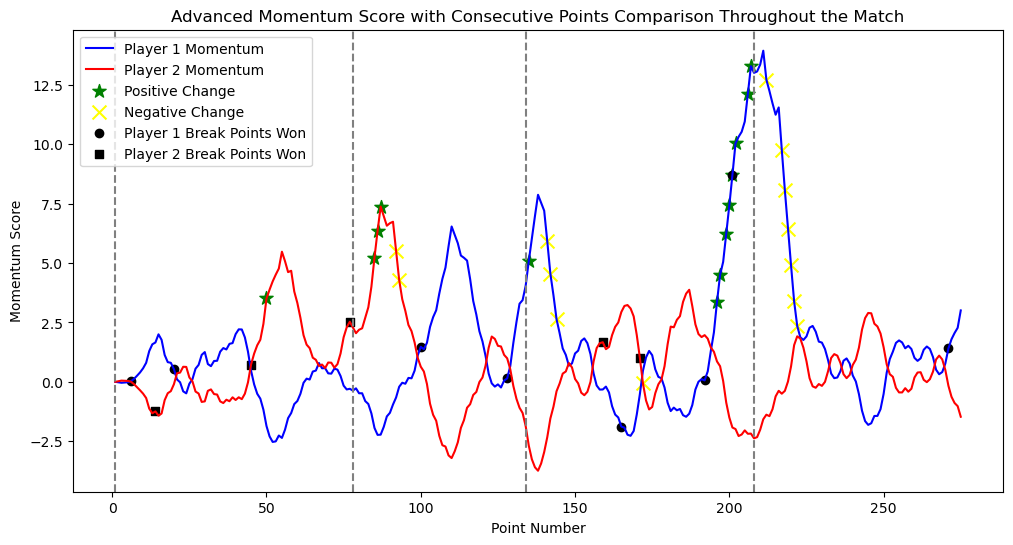

Player 1 had a Negative shift at point number 25, during set 1, game 5. GET -1.092343433405083
Player 1 had a Negative shift at point number 26, during set 1, game 5. GET -1.2259534938663532
Player 1 had a Negative shift at point number 28, during set 1, game 6. GET -1.0897526434555789
Player 1 had a Negative shift at point number 30, during set 1, game 6. GET -1.0919510180752452
Player 1 had a Negative shift at point number 32, during set 1, game 6. GET -1.0430532622622848
Player 1 had a Positive shift at point number 40, during set 1, game 7. GET 1.1991281368005697
Player 1 had a Positive shift at point number 41, during set 1, game 8. GET 1.003229692956182
Player 1 had a Positive shift at point number 43, during set 1, game 8. GET 1.2710494016497687
Player 1 had a Positive shift at point number 44, during set 1, game 8. GET 1.0046236675991267
Player 1 had a Positive shift at point number 195, during set 3, game 8. GET 1.3581329122931245
Player 1 had a Positive shift at point number 

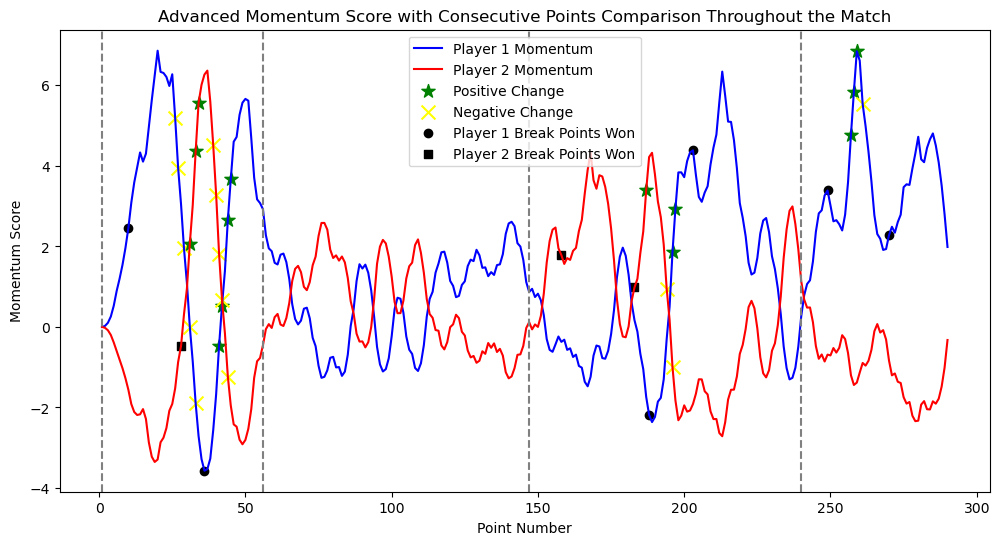

Player 1 had a Negative shift at point number 33, during set 1, game 6. GET -1.0287755597298822
Player 1 had a Negative shift at point number 34, during set 1, game 6. GET -1.1113007391062268
Player 1 had a Positive shift at point number 79, during set 2, game 3. GET 1.1638770333531117
Player 1 had a Positive shift at point number 80, during set 2, game 3. GET 1.0377088640073762
Player 1 had a Negative shift at point number 84, during set 2, game 4. GET -1.013540970542727
Player 1 had a Positive shift at point number 115, during set 3, game 2. GET 1.5259986078270575
Player 1 had a Positive shift at point number 116, during set 3, game 2. GET 1.6024722928833164
Player 1 had a Negative shift at point number 120, during set 3, game 3. GET -1.9746525027048794
Player 1 had a Negative shift at point number 121, during set 3, game 3. GET -1.8202284340375945
Player 1 had a Negative shift at point number 122, during set 3, game 3. GET -1.2423787105193842
Player 2 had a Positive shift at point n

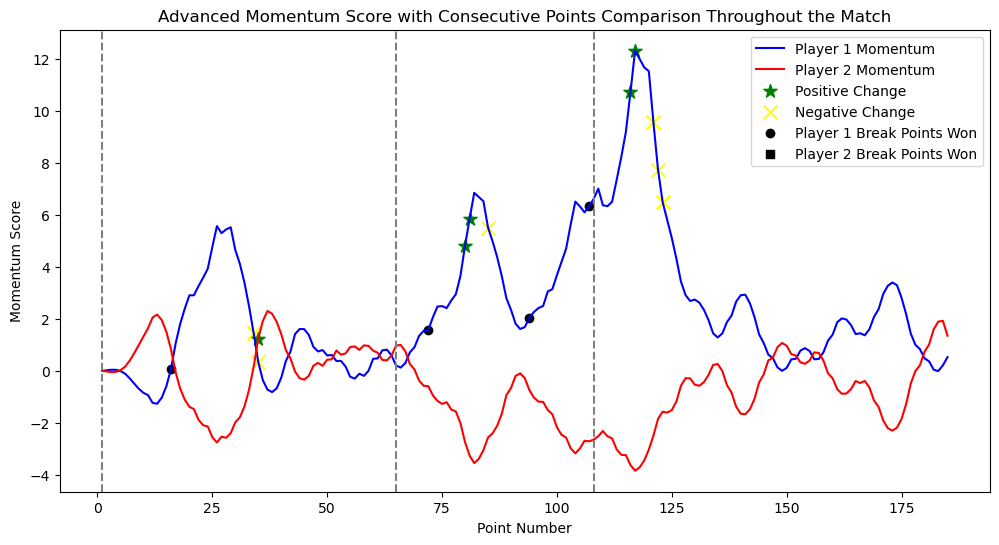

Player 1 had a Positive shift at point number 112, during set 2, game 7. GET 1.008874597511282
Player 2 had a Positive shift at point number 100, during set 2, game 4. GET 1.1857120781452941
Player 2 had a Positive shift at point number 101, during set 2, game 4. GET 1.0660945527275612
Player 2 had a Positive shift at point number 102, during set 2, game 5. GET 1.050170284473309
Player 2 had a Negative shift at point number 111, during set 2, game 6. GET -1.0611677576289367
Player 2 had a Negative shift at point number 112, during set 2, game 7. GET -1.1361893898392985
Player 2 had a Positive shift at point number 149, during set 3, game 3. GET 1.071862732950411
Player 2 had a Negative shift at point number 154, during set 3, game 4. GET -1.222696860981773
Player 2 had a Negative shift at point number 155, during set 3, game 4. GET -1.2272144106201193


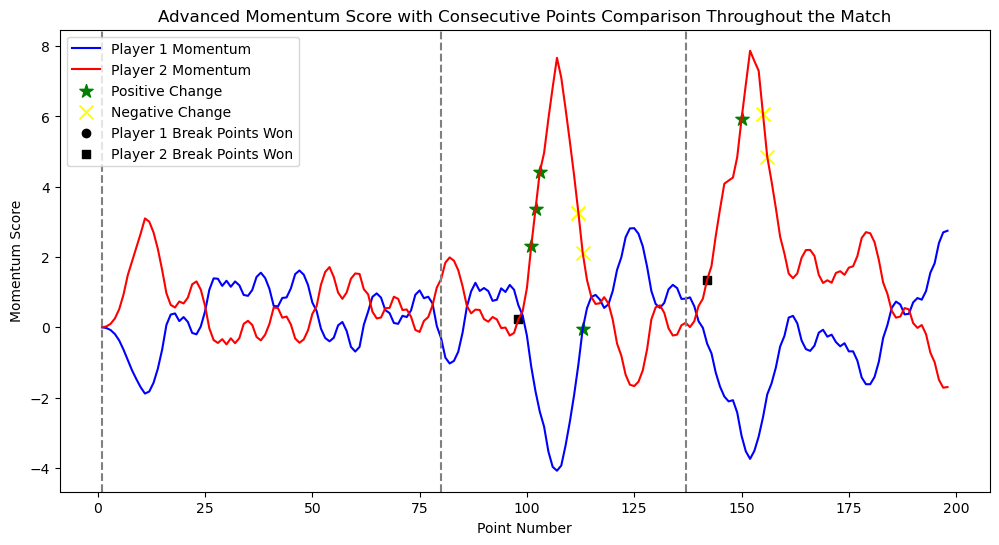

Player 1 had a Positive shift at point number 106, during set 3, game 3. GET 1.0831888750598946
Player 2 had a Positive shift at point number 41, during set 1, game 8. GET 1.1629550539250673
Player 2 had a Positive shift at point number 69, during set 2, game 3. GET 1.3991673469426704
Player 2 had a Positive shift at point number 70, during set 2, game 3. GET 1.3155783286901084
Player 2 had a Positive shift at point number 79, during set 2, game 5. GET 1.0980630720583875
Player 2 had a Positive shift at point number 80, during set 2, game 5. GET 1.1535771821424188
Player 2 had a Negative shift at point number 85, during set 2, game 6. GET -1.8413090444323554
Player 2 had a Negative shift at point number 86, during set 2, game 6. GET -1.714380555303177
Player 2 had a Negative shift at point number 87, during set 2, game 6. GET -1.0411239815476048
Player 2 had a Negative shift at point number 104, during set 3, game 3. GET -1.3531555496927439
Player 2 had a Negative shift at point number

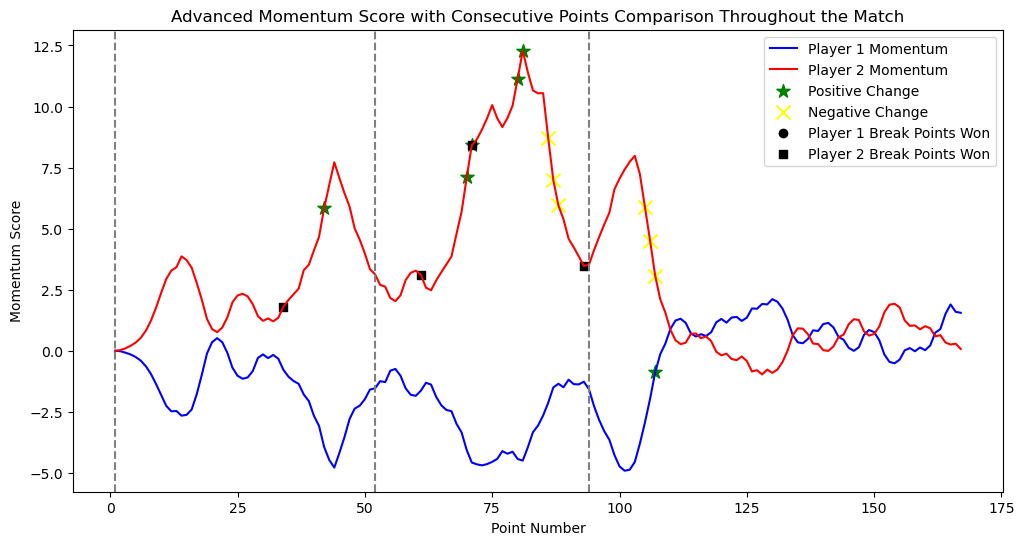

Player 1 had a Positive shift at point number 89, during set 2, game 5. GET 1.5014296453079892
Player 1 had a Positive shift at point number 90, during set 2, game 5. GET 1.63317784226553
Player 1 had a Negative shift at point number 96, during set 2, game 7. GET -1.195560596449793
Player 1 had a Negative shift at point number 97, during set 2, game 7. GET -1.1917926050147
Player 1 had a Negative shift at point number 98, during set 2, game 7. GET -1.2020017368605327
Player 1 had a Negative shift at point number 99, during set 2, game 8. GET -1.1995119784284296
Player 2 had a Positive shift at point number 50, during set 1, game 9. GET 1.1013451273036163
Player 2 had a Negative shift at point number 89, during set 2, game 5. GET -1.033328801750572


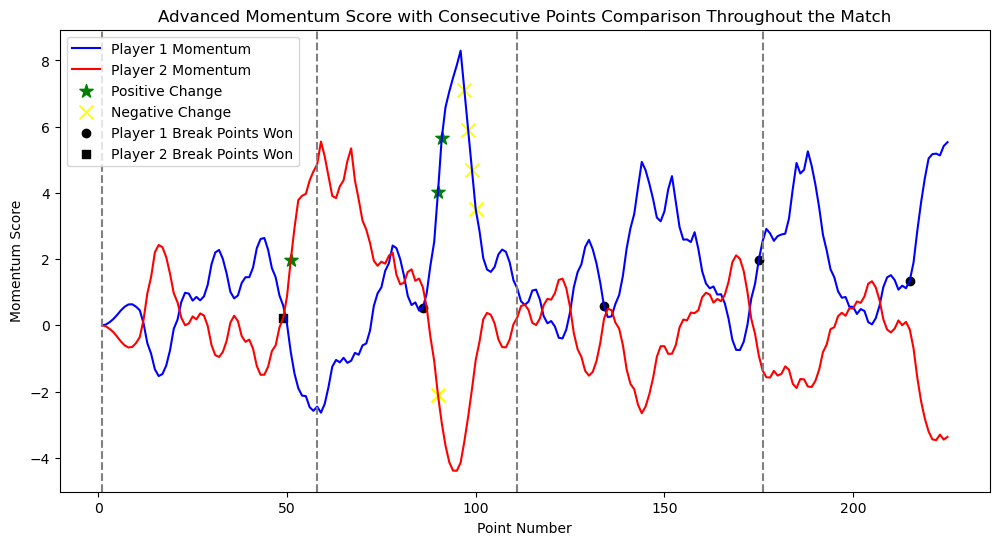

Player 1 had a Positive shift at point number 98, during set 2, game 5. GET 1.0531133314323249
Player 1 had a Negative shift at point number 103, during set 2, game 6. GET -1.102494082676258
Player 2 had a Negative shift at point number 129, during set 2, game 11. GET -1.0847148780338927
Player 2 had a Negative shift at point number 130, during set 2, game 11. GET -1.1098260898668535
Player 2 had a Positive shift at point number 223, during set 3, game 13. GET 1.0281907394828225
Player 2 had a Negative shift at point number 272, during set 4, game 9. GET -1.062839856398724


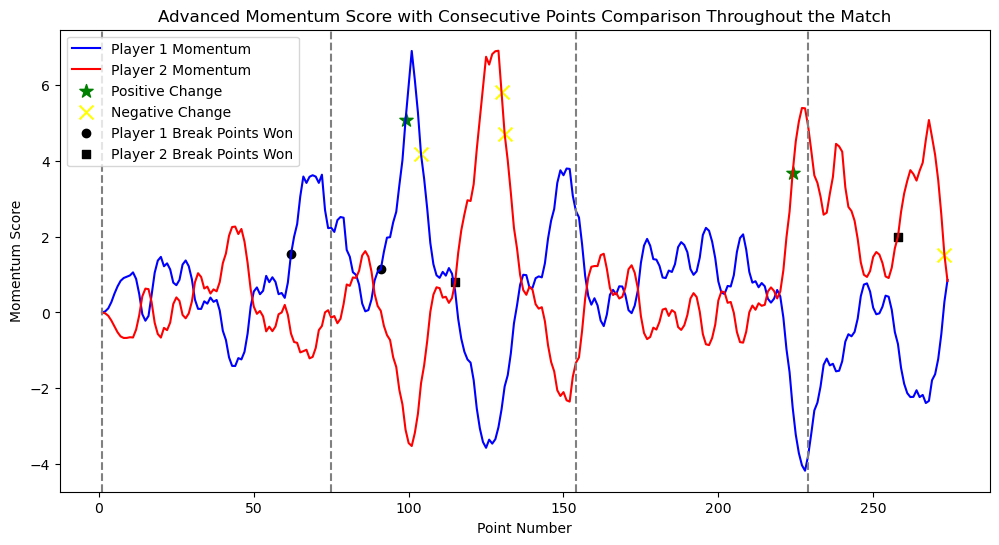

Player 1 had a Positive shift at point number 89, during set 2, game 4. GET 1.4706715360708746
Player 1 had a Positive shift at point number 90, during set 2, game 5. GET 1.7238983429440466
Player 1 had a Positive shift at point number 91, during set 2, game 5. GET 2.036186547555131
Player 1 had a Positive shift at point number 92, during set 2, game 5. GET 1.7503711590994406
Player 1 had a Positive shift at point number 93, during set 2, game 5. GET 1.896016735209626
Player 1 had a Negative shift at point number 100, during set 2, game 5. GET -1.6371315065597631
Player 1 had a Negative shift at point number 101, during set 2, game 5. GET -1.5539905634283322
Player 1 had a Negative shift at point number 102, during set 2, game 5. GET -1.5114353695022151
Player 1 had a Negative shift at point number 103, during set 2, game 5. GET -1.094923674098803


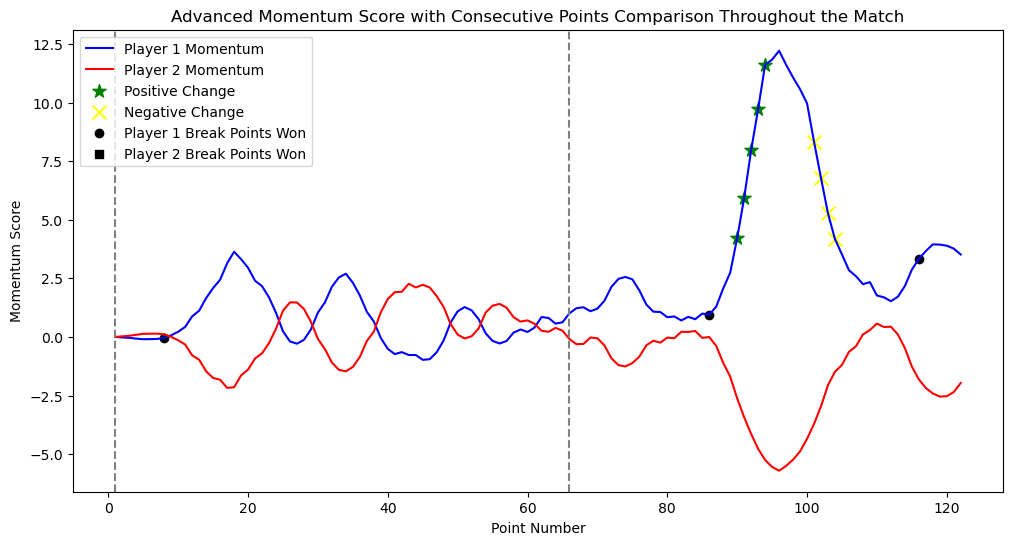

Player 1 had a Negative shift at point number 229, during set 5, game 1. GET -1.0541174592616391
Player 1 had a Negative shift at point number 230, during set 5, game 1. GET -1.0747952973640755
Player 1 had a Positive shift at point number 239, during set 5, game 3. GET 1.3530169749494565
Player 1 had a Positive shift at point number 240, during set 5, game 3. GET 1.2682623299974143
Player 1 had a Negative shift at point number 244, during set 5, game 4. GET -1.3199455805101303
Player 2 had a Positive shift at point number 20, during set 1, game 5. GET 1.7912939109603667
Player 2 had a Negative shift at point number 25, during set 1, game 6. GET -1.0441558667784365
Player 2 had a Negative shift at point number 26, during set 1, game 6. GET -1.0221331810280754
Player 2 had a Negative shift at point number 27, during set 1, game 6. GET -1.052566236737296
Player 2 had a Negative shift at point number 28, during set 1, game 6. GET -1.1418575978194712
Player 2 had a Negative shift at point 

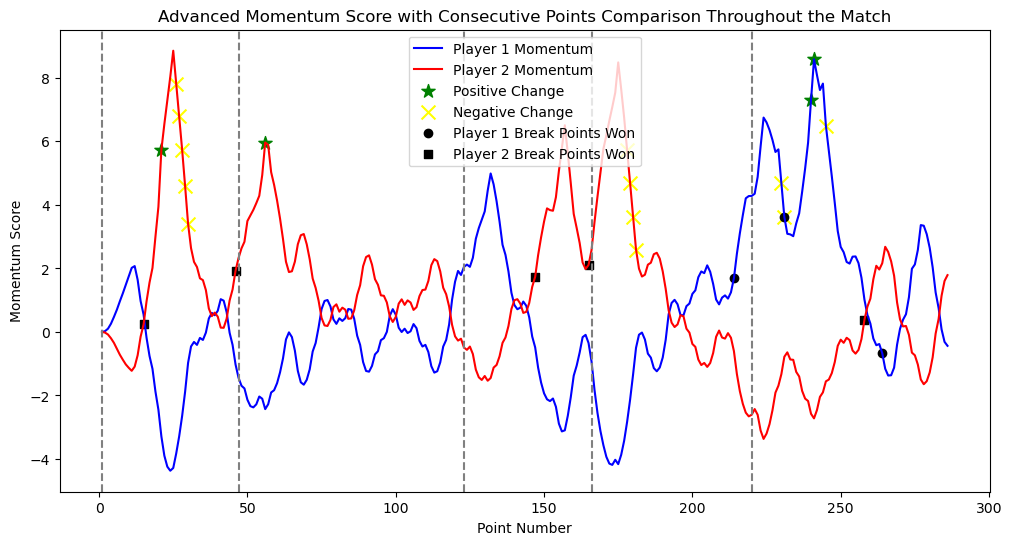

Player 1 had a Positive shift at point number 159, during set 2, game 10. GET 1.221652836780283
Player 1 had a Positive shift at point number 160, during set 2, game 10. GET 1.1383486755980643
Player 1 had a Positive shift at point number 171, during set 3, game 2. GET 1.0616632143965221
Player 1 had a Positive shift at point number 172, during set 3, game 2. GET 1.6178198685109884
Player 1 had a Positive shift at point number 173, during set 3, game 2. GET 1.6595092400284912
Player 1 had a Positive shift at point number 174, during set 3, game 2. GET 1.6258659277091976
Player 1 had a Negative shift at point number 179, during set 3, game 3. GET -1.337407757666531
Player 1 had a Positive shift at point number 183, during set 3, game 4. GET 1.0469314583975997
Player 1 had a Positive shift at point number 184, during set 3, game 4. GET 1.2063676166531536
Player 1 had a Positive shift at point number 185, during set 3, game 5. GET 1.9867353050721714
Player 1 had a Negative shift at point 

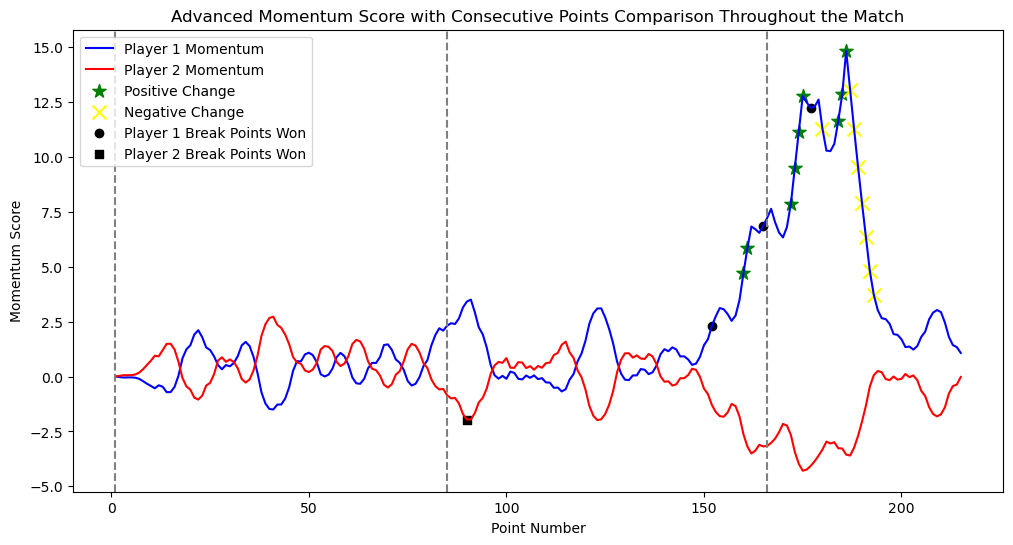

Player 1 had a Positive shift at point number 85, during set 2, game 7. GET 1.4723724782835408
Player 1 had a Positive shift at point number 86, during set 2, game 7. GET 1.2996583019419279
Player 1 had a Positive shift at point number 87, during set 2, game 7. GET 1.139147594246889
Player 1 had a Positive shift at point number 88, during set 2, game 8. GET 1.1096745553936636
Player 1 had a Positive shift at point number 91, during set 2, game 8. GET 1.034679577606072
Player 1 had a Negative shift at point number 95, during set 2, game 9. GET -1.0932963416452113
Player 1 had a Negative shift at point number 96, during set 2, game 9. GET -1.1722558437654582
Player 1 had a Negative shift at point number 97, during set 2, game 9. GET -1.2219204700680324
Player 1 had a Negative shift at point number 98, during set 2, game 9. GET -1.2517796128631713
Player 1 had a Positive shift at point number 116, during set 3, game 2. GET 1.1305293826569711
Player 1 had a Positive shift at point number 1

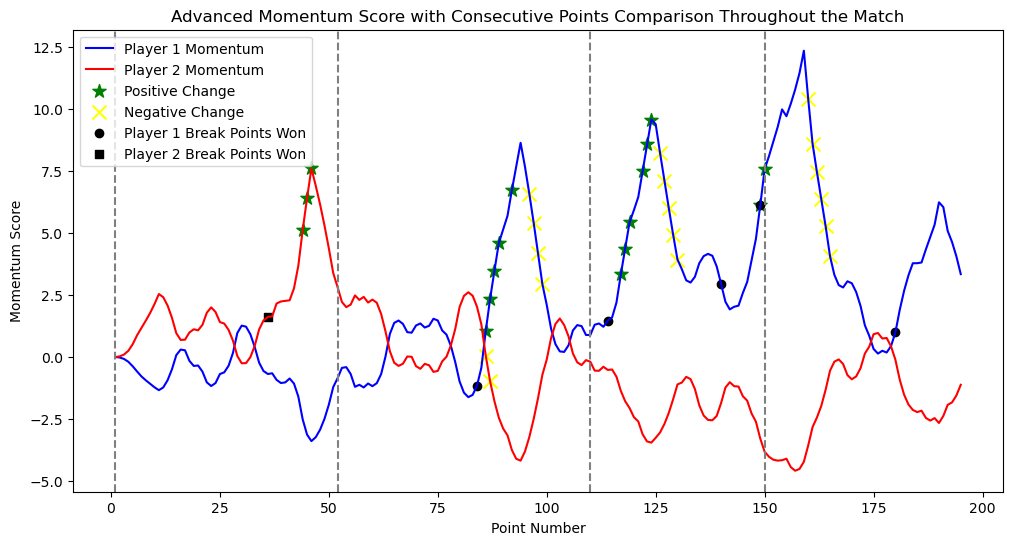

Player 1 had a Positive shift at point number 80, during set 2, game 2. GET 1.0180065626459767
Player 1 had a Negative shift at point number 86, during set 2, game 3. GET -1.0304240622672465
Player 1 had a Negative shift at point number 87, during set 2, game 3. GET -1.0539879164071593
Player 1 had a Negative shift at point number 88, during set 2, game 3. GET -1.0498854134956446
Player 1 had a Positive shift at point number 119, during set 2, game 9. GET 1.1819626489408064
Player 1 had a Negative shift at point number 124, during set 2, game 9. GET -1.0003043236311049
Player 1 had a Negative shift at point number 125, during set 3, game 1. GET -1.0667195101275118
Player 1 had a Positive shift at point number 164, during set 3, game 8. GET 1.0851006357394566
Player 1 had a Negative shift at point number 327, during set 5, game 10. GET -1.0447782536220114
Player 1 had a Negative shift at point number 328, during set 5, game 10. GET -1.1143375895362864


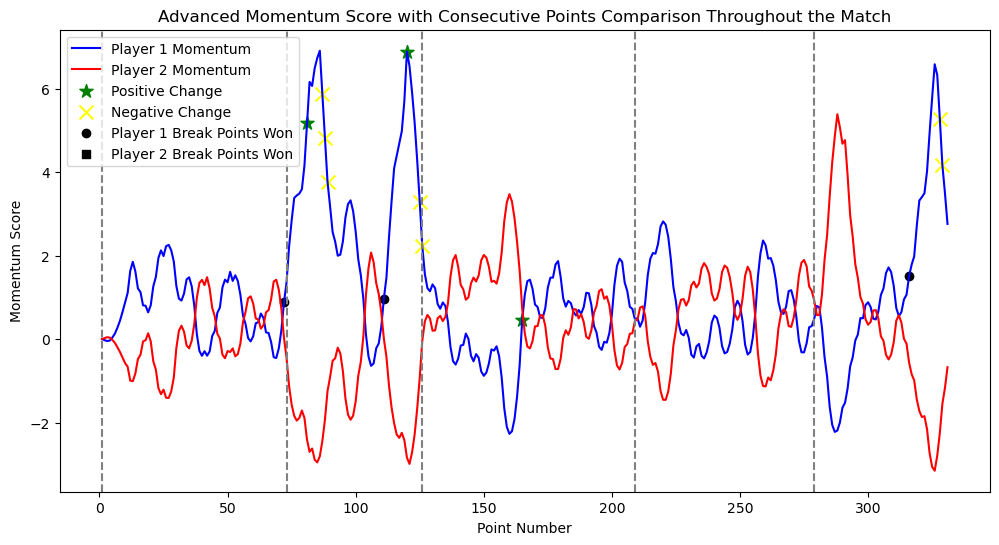

Player 1 had a Positive shift at point number 127, during set 2, game 9. GET 1.0298413943664577
Player 1 had a Negative shift at point number 230, during set 4, game 3. GET -1.0324968340263276
Player 2 had a Positive shift at point number 80, during set 2, game 2. GET 1.101097347435882
Player 2 had a Positive shift at point number 264, during set 4, game 9. GET 1.3719016208661232
Player 2 had a Positive shift at point number 265, during set 4, game 9. GET 1.315692832391373
Player 2 had a Positive shift at point number 266, during set 4, game 9. GET 1.1231970169860936


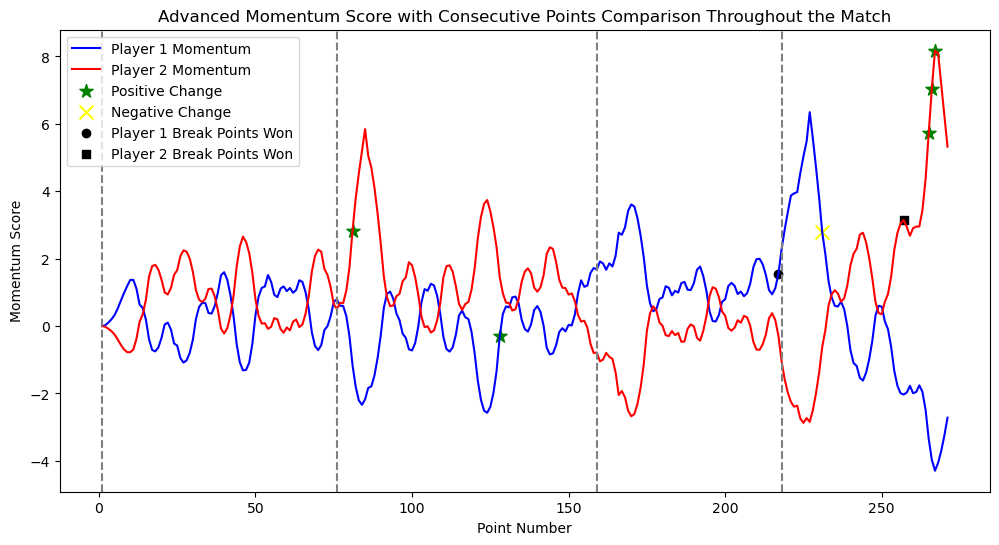

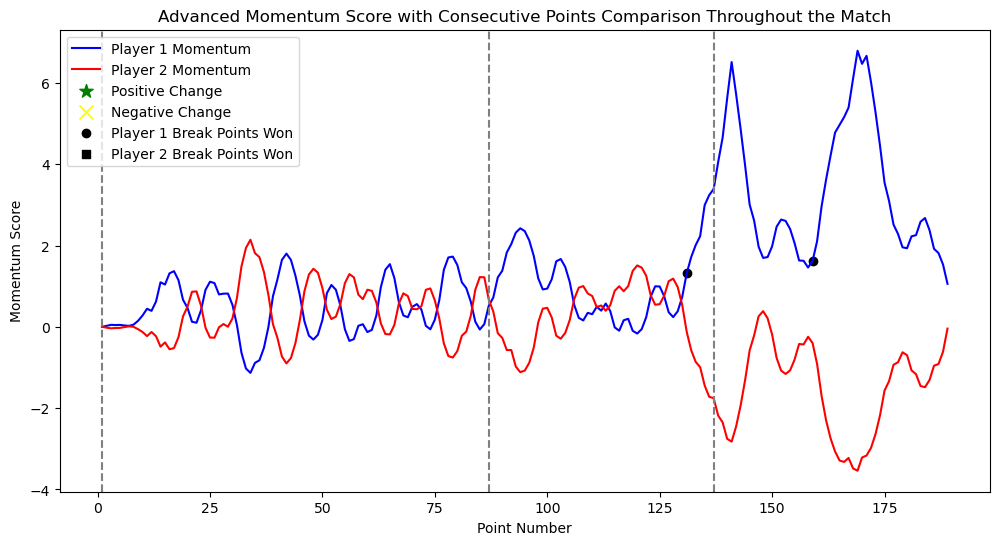

Player 1 had a Negative shift at point number 30, during set 1, game 6. GET -1.0086895305638626
Player 1 had a Positive shift at point number 236, during set 5, game 2. GET 1.0717281671057384
Player 1 had a Positive shift at point number 240, during set 5, game 2. GET 1.1186618423944257
Player 1 had a Negative shift at point number 257, during set 5, game 4. GET -1.6235298747670797
Player 1 had a Negative shift at point number 258, during set 5, game 4. GET -1.1077076585696615
Player 1 had a Positive shift at point number 268, during set 5, game 5. GET 1.0744654769800261
Player 1 had a Positive shift at point number 269, during set 5, game 6. GET 1.0087044054902998
Player 1 had a Negative shift at point number 270, during set 5, game 6. GET -1.1917595904336418
Player 1 had a Negative shift at point number 271, during set 5, game 6. GET -1.196556916321562
Player 1 had a Negative shift at point number 272, during set 5, game 6. GET -1.1519589219346615
Player 2 had a Positive shift at poi

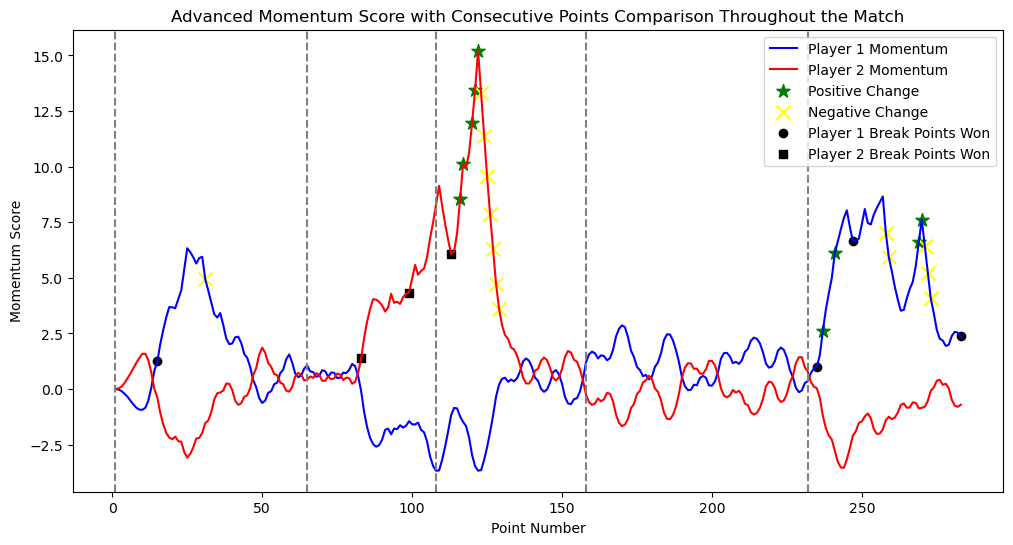

Player 1 had a Positive shift at point number 49, during set 1, game 10. GET 1.0487713209516882
Player 1 had a Negative shift at point number 59, during set 2, game 2. GET -1.0083015819422991
Player 1 had a Negative shift at point number 60, during set 2, game 2. GET -1.0971542998854549
Player 1 had a Negative shift at point number 61, during set 2, game 2. GET -1.1597367454242518
Player 1 had a Negative shift at point number 62, during set 2, game 2. GET -1.2249324931424646
Player 1 had a Positive shift at point number 70, during set 2, game 4. GET 1.5029124346427714
Player 1 had a Positive shift at point number 71, during set 2, game 4. GET 1.6899410188747783
Player 1 had a Positive shift at point number 72, during set 2, game 5. GET 1.9143741624953687
Player 1 had a Positive shift at point number 73, during set 2, game 5. GET 2.0528123153375653
Player 1 had a Negative shift at point number 78, during set 2, game 6. GET -1.3823783720838794
Player 1 had a Negative shift at point numbe

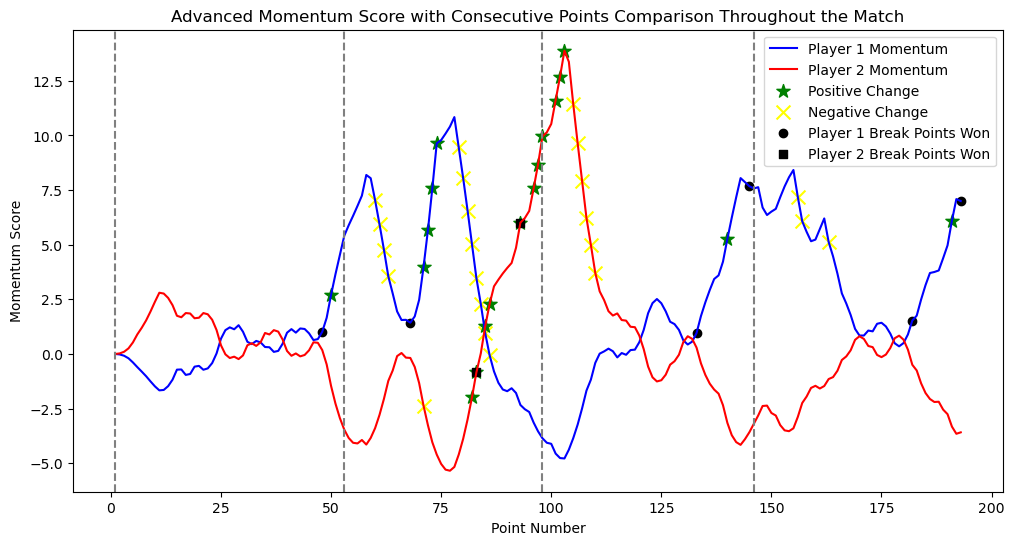

Player 1 had a Negative shift at point number 67, during set 2, game 2. GET -1.1235690443819006
Player 1 had a Negative shift at point number 72, during set 2, game 3. GET -1.117266841855789
Player 1 had a Negative shift at point number 131, during set 3, game 6. GET -1.0815473100338755
Player 2 had a Positive shift at point number 89, during set 2, game 5. GET 1.793944009970832
Player 2 had a Positive shift at point number 90, during set 2, game 6. GET 2.1779147159797496
Player 2 had a Positive shift at point number 91, during set 2, game 6. GET 2.522717926233053
Player 2 had a Negative shift at point number 96, during set 2, game 7. GET -2.099382496645582
Player 2 had a Negative shift at point number 97, during set 2, game 7. GET -1.9310080259316003
Player 2 had a Negative shift at point number 98, during set 2, game 7. GET -1.8170765149564598
Player 2 had a Negative shift at point number 99, during set 2, game 7. GET -1.6946288026065588
Player 2 had a Negative shift at point number 

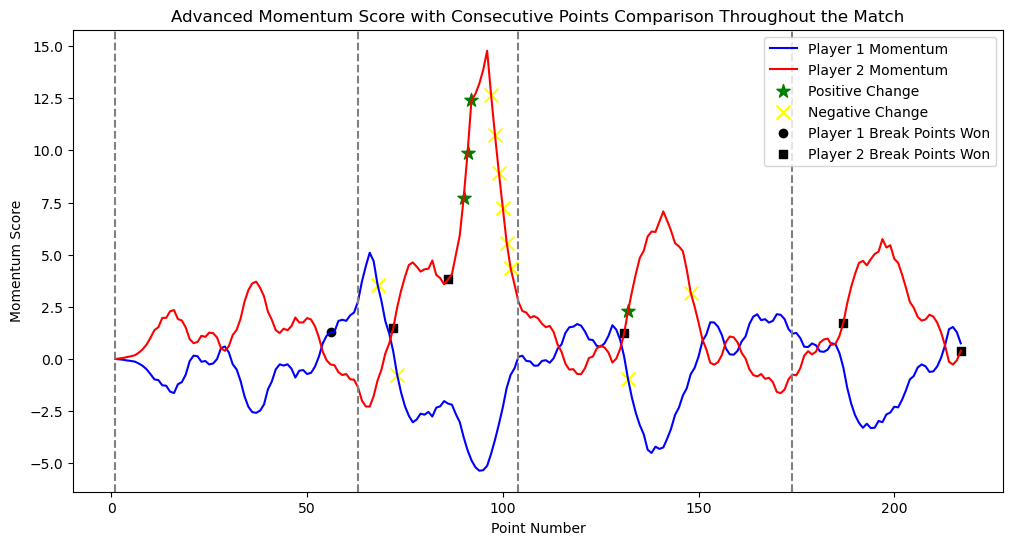

Player 1 had a Negative shift at point number 61, during set 2, game 2. GET -1.0602494673507343
Player 1 had a Negative shift at point number 62, during set 2, game 2. GET -1.1867589776024363
Player 1 had a Negative shift at point number 85, during set 2, game 6. GET -1.124847034792963
Player 1 had a Negative shift at point number 86, during set 2, game 6. GET -1.1695152133412057
Player 1 had a Positive shift at point number 113, during set 3, game 3. GET 1.4365943275288338
Player 1 had a Negative shift at point number 123, during set 3, game 4. GET -1.0528449980506505
Player 1 had a Negative shift at point number 126, during set 3, game 5. GET -1.6000950151599271
Player 1 had a Negative shift at point number 127, during set 3, game 5. GET -1.162338180902684
Player 1 had a Negative shift at point number 128, during set 3, game 5. GET -1.312950800853267
Player 1 had a Negative shift at point number 129, during set 3, game 5. GET -1.4248073562945685
Player 1 had a Negative shift at point

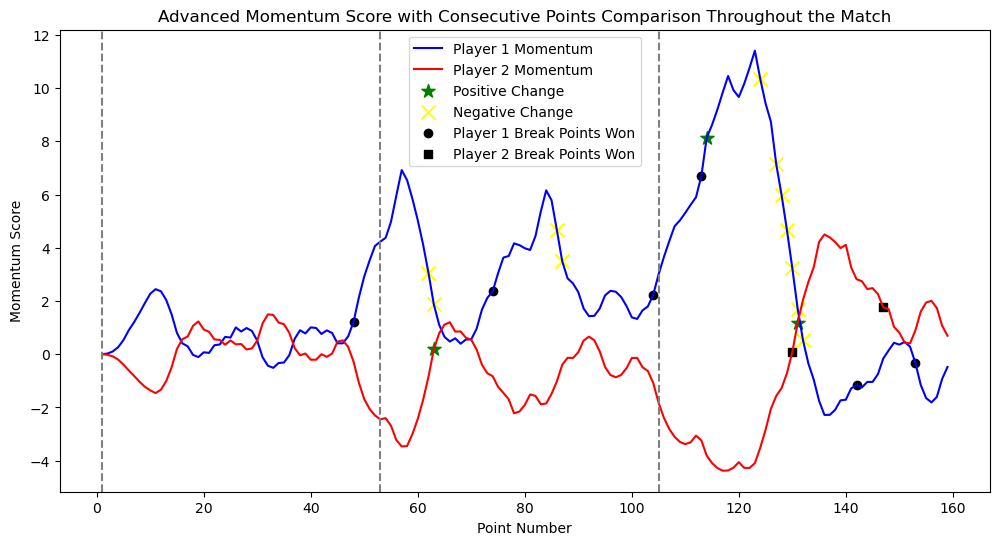

Player 1 had a Positive shift at point number 144, during set 3, game 4. GET 1.1595118319313233
Player 2 had a Negative shift at point number 30, during set 1, game 5. GET -1.081517608466004


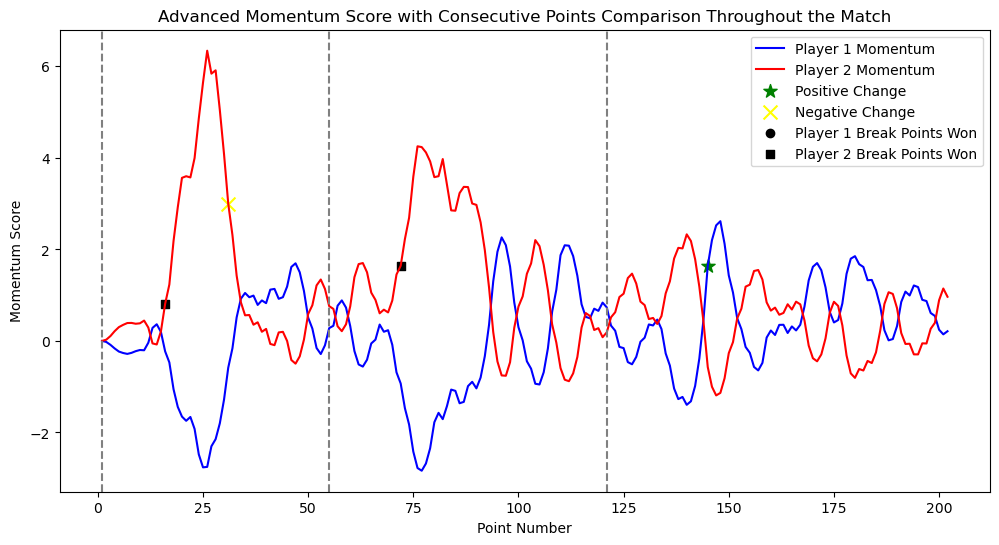

Player 1 had a Negative shift at point number 73, during set 2, game 4. GET -1.039040566914645
Player 1 had a Negative shift at point number 75, during set 2, game 4. GET -1.0284449237272906
Player 1 had a Positive shift at point number 206, during set 3, game 7. GET 1.4741074101650073
Player 1 had a Positive shift at point number 207, during set 3, game 7. GET 1.373956449831213
Player 1 had a Positive shift at point number 208, during set 3, game 7. GET 1.242066875875615
Player 1 had a Positive shift at point number 218, during set 4, game 2. GET 1.108859803161998
Player 1 had a Negative shift at point number 224, during set 4, game 3. GET -1.658076410483547
Player 1 had a Negative shift at point number 225, during set 4, game 3. GET -1.6119398181008986
Player 1 had a Negative shift at point number 226, during set 4, game 3. GET -1.748016026270487
Player 1 had a Negative shift at point number 227, during set 4, game 3. GET -1.6510336066280296
Player 1 had a Negative shift at point num

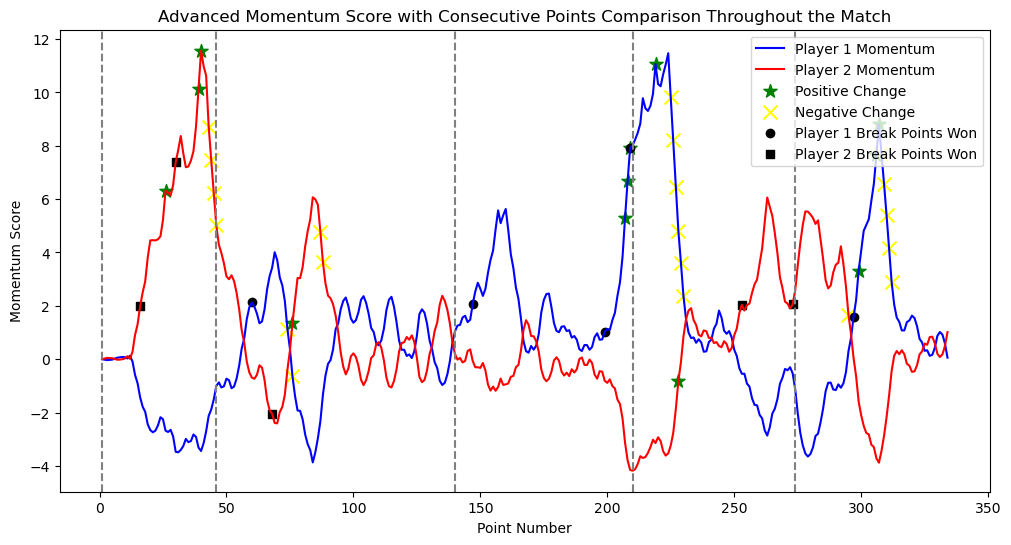

In [6]:
for target_match_id in target_match_ids:
    # 筛选数据
    filtered_data = df[df['match_id'] == target_match_id].copy()
    
    # 计算综合势头得分
    filtered_data['comprehensive_momentum_1'] = calculate_comprehensive_momentum(filtered_data, player_number=1)
    filtered_data['comprehensive_momentum_2'] = calculate_comprehensive_momentum(filtered_data, player_number=2)
    
    # Define the threshold for a significant momentum shift
    threshold = 1.0
    
    # Initialize lists to store the points of positive and negative shifts for both players
    shifts_player_1 = []
    shifts_player_2 = []
    
    # Calculate the momentum change for each point and find shifts
    for i in range(1, len(filtered_data)):
        change_1 = filtered_data['comprehensive_momentum_1'].iloc[i] - filtered_data['comprehensive_momentum_1'].iloc[i - 1]
        change_2 = filtered_data['comprehensive_momentum_2'].iloc[i] - filtered_data['comprehensive_momentum_2'].iloc[i - 1] 
            
        if abs(change_1) >= threshold:
            shift_type = 'Positive' if change_1 > 0 else 'Negative'
            shifts_player_1.append((i, shift_type, change_1))
        if abs(change_2) >= threshold:
            shift_type = 'Positive' if change_2 > 0 else 'Negative'
            shifts_player_2.append((i, shift_type, change_2))
    
    # Annotation
    for point, shift_type, change in shifts_player_1:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(f"Player 1 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")
    
    for point, shift_type, change in shifts_player_2:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(f"Player 2 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")
    
    # 筛选出破发成功的点
    break_points_won_1 = filtered_data[filtered_data['p1_break_pt_won'] == 1]
    break_points_won_2 = filtered_data[filtered_data['p2_break_pt_won'] == 1]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_1'], label='Player 1 Momentum', color='blue')
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_2'], label='Player 2 Momentum', color='red')
    
    plt.scatter([], [], color='green', marker='*', s=100, label='Positive Change')
    plt.scatter([], [], color='yellow', marker='x', s=100, label='Negative Change')
    
    for point, shift_type, _ in shifts_player_1:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'yellow'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point], 
                    color=color, marker=marker, s=100)
        
    for point, shift_type, _ in shifts_player_2:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'yellow'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_2'].iloc[point], 
                    color=color, marker=marker, s=100)
    
    # 用黑色点标记破发成功的点
    plt.scatter(break_points_won_1['point_no'], break_points_won_1['comprehensive_momentum_1'], color='black', marker='o', label='Player 1 Break Points Won')
    plt.scatter(break_points_won_2['point_no'], break_points_won_2['comprehensive_momentum_2'], color='black', marker='s', label='Player 2 Break Points Won')
    
    # 添加盘结束的垂直线
    last_set_no = 0
    for i, row in filtered_data.iterrows():
        if row['set_no'] != last_set_no:
            plt.axvline(x=row['point_no'], color='grey', linestyle='--')
            last_set_no = row['set_no']
            
    # Add labels and title to the plot
    plt.xlabel('Point Number')
    plt.ylabel('Momentum Score')
    plt.title('Advanced Momentum Score with Consecutive Points Comparison Throughout the Match')
    plt.legend()
    plt.show()
    
    # filename = 'data_with_momentum/' + target_match_id + '.csv'
    # filtered_data.to_csv(filename, index=False)
    
    # # 编码发球相关特征
    # serve_width_dummies = pd.get_dummies(filtered_data['serve_width'], prefix='serve_width')
    # serve_depth_dummies = pd.get_dummies(filtered_data['serve_depth'], prefix='serve_depth')
    # return_depth_dummies = pd.get_dummies(filtered_data['return_depth'], prefix='return_depth')
    # 
    # # Concatenate the new columns with the original dataframe
    # encoded_df = pd.concat([filtered_data, serve_width_dummies, serve_depth_dummies, return_depth_dummies], axis=1)
    # new_filename = 'data_with_momentum_1hot/' + target_match_id + '.csv'
    # encoded_df.to_csv(new_filename, index=False)

**v3.0 let threshold = 8, window = 3**

1. 66
    1 -8.76, 2 +8.36    1发球，2胜  40-30 -> 40-40
2. 74
    1 -12.24, 2 +12.09  2发球，2胜  40-30 -> 40-40  跑动距离尤其长（双方平均不到20，120-93），拍数多（29，平均4.46）
3. ...

    峰谷值体现在多拍回合，说明要降低拍数和跑动距离的影响。


**v3.1 let threshold = 4, window = 3， 调整拍数和跑动距离部分的系数**
1. 218
    1 -5.33             2发球，2胜 30-0 -> 30-15
2. ...

    个人觉得大致可以自圆其说，还要增加破发/保发的特征

**v3.2 ...**
1. ...  